# Test data loading from different sources

- ARC-AGI
- ARC-AGI-2
- SRaven
- BBH

In [36]:
import os
import sys
import jax
import jax.numpy as jnp
from einops import rearrange
import matplotlib.pyplot as plt

# make SRaven datasets
sys.path.append(os.path.abspath('..'))
from algorithms.hyla.hyla.data.raven import create_raven_datasets

In [11]:
# Test SRaven datasets

num_features = 8
feature_maxval = 64
grid_size = 3
permute_features = True

with jax.disable_jit(False):
    (ds_train, ds_eval, ds_callback), _ = create_raven_datasets(
        batch_size := 128,
        seq_len := ((9 - 1) * num_features) + num_features,
        num_train=1280, # 128000
        num_test=128,
        num_ood=128,
        num_features=num_features,
        feature_maxval=feature_maxval,
        grid_size=grid_size,
        permute_features=permute_features,
        frac_ood=0.25,
        seed=0,
    )

In [ ]:
## notes to self
## from --> Experiment: for step, batch in enumerate(iter(self.train_loader)):
## from --> Experiment:



n_batches = 4
batches = []
di_train = iter(ds_train)
for n, b in zip(range(n_batches), ds_train):
    batches.append(b)

In [ ]:
# examine some batches
# raven batches are shape (examples, num_features * 9, feature_maxval)
bx = batches[0].x
by = batches[0].y
print(bx.shape)
print(by.shape)

(128, 72, 64)
(128, 8)


In [65]:
# examine single example
ex = bx[0]
ex = rearrange(ex, '(a b) c -> a b c', a=9, b=8)
# verify one-hot encoding
jnp.unique(ex, return_counts=True)

(Array([0., 1.], dtype=float32), Array([4544,   64], dtype=int32))

In [66]:
ex = ex.argmax(axis=-1)
ex.shape

(9, 8)

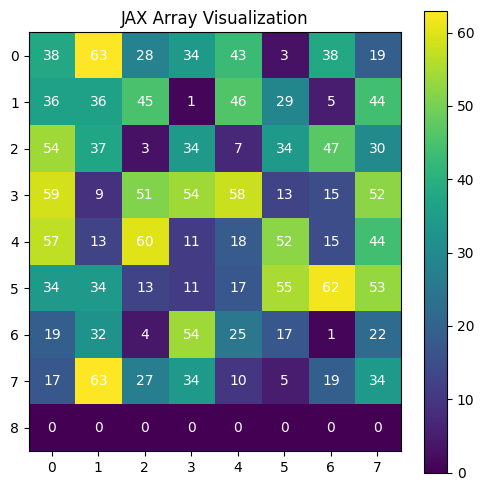

In [ ]:
# create a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Use imshow to visualize the array with a colormap
# 'viridis' is a good default, but you can try others like 'jet', 'plasma', 'cividis'
im = ax.imshow(ex, cmap='viridis')

# Add colorbar
cbar = plt.colorbar(im)

# Optionally, add text annotations showing the actual integer values
for i in range(ex.shape[0]):
    for j in range(ex.shape[1]):
        ax.text(j, i, f'{int(ex[i, j])}', 
                ha='center', va='center', color='white')

plt.title('JAX Array Visualization')
plt.show()

In [56]:
num_examples = 1
num_features = 8
maxval = feature_maxval

rng = jax.random.PRNGKey(0)

In [ ]:
def constant(rng):
    const = jax.random.randint(rng, shape=(num_examples, 1), minval=0, maxval=maxval)
    return jnp.broadcast_to(const, shape=(num_examples, seq_len))

def progression(rng, inc: int):
    start = jax.random.randint(rng, shape=(num_examples, 1), minval=0, maxval=maxval)
    return (start + inc * jnp.arange(0, seq_len)[jnp.newaxis]) % maxval

def arithmetic(rng, subtract: bool):
    xs = jax.random.randint(rng, shape=(num_examples, seq_len-1), minval=0, maxval=maxval)
    if subtract:
        xs = xs.at[:, 1:].set(xs[:, 1:] * (-1))

    res = jnp.sum(xs, keepdims=True, axis=1) % maxval
    return jnp.concatenate((jnp.abs(xs), res), axis=-1)

def distribute_three(rng):
    rng_choice, rng_perm = jax.random.split(rng)
    symbols = jax.random.choice(rng_choice, maxval, shape=(seq_len, ), replace=False)
    symbols = jnp.broadcast_to(symbols, shape=(num_examples, seq_len))
    return jax.random.permutation(rng_perm, symbols, axis=1, independent=True)

In [59]:
pg = progression(rng, 1)
pg.shape

(1, 72)

In [60]:
pg

Array([[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,  0,  1,  2,  3,  4,
         5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44]], dtype=int32)

In [67]:
data = ex

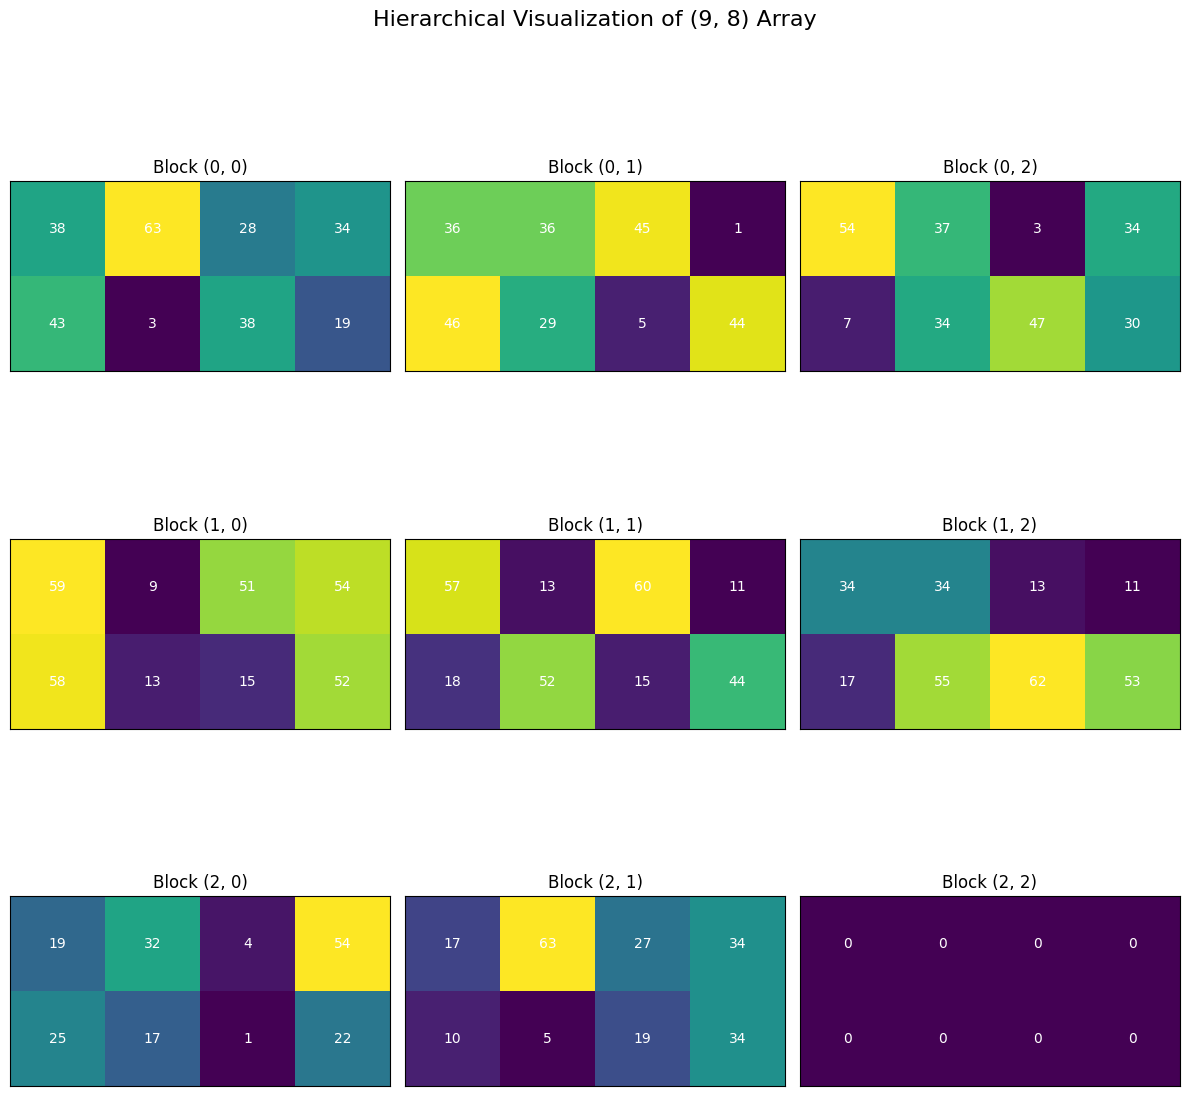

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Define a colormap
cmap = plt.cm.viridis

# Loop through the 9 blocks (3×3 grid)
for block_idx in range(9):
    # Calculate row and column in the original array
    block_row = block_idx // 3
    block_col = block_idx % 3
    
    # Extract the corresponding 2×4 sub-array
    # Each block corresponds to one row of the original array
    block_data = data[block_idx].reshape(2, 4)
    
    # Plot this block in its corresponding axis
    im = axes[block_idx].imshow(block_data, cmap=cmap)
    
    # Add text annotations with values
    for i in range(2):
        for j in range(4):
            axes[block_idx].text(j, i, f'{int(block_data[i, j])}', 
                              ha='center', va='center', color='white')
    
    # Add titles to each block
    axes[block_idx].set_title(f'Block ({block_row}, {block_col})')
    
    # Remove ticks for cleaner appearance
    axes[block_idx].set_xticks([])
    axes[block_idx].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.suptitle('Hierarchical Visualization of (9, 8) Array', fontsize=16, y=1.02)
plt.show()

# Load some ARC data -- ensure consistent formatting

# Data Augmentation Primitives + Pretraining